# Example: counting events and throwing dice

Jelle, October 2023

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import nafi

# Use float64 in jax for better precision
import jax
jax.config.update("jax_enable_x64", True)

Consider a counting experiment without background. We observe $n$ events, and want to set an upper limit on the number of expected events $\mu$. We use the test statistic:

$\displaystyle q_\mu = -2 \, \mathrm{\Theta}(\mu - \hat{\mu}) \, \ln \frac{L(\mu)}{L(\hat{\mu})} ,$

where the best-fit hypothesis $\hat{\mu} = n$. The step function ensures we get upper limits:

  * Outcomes that are excesses ($\hat{\mu} = n > \mu$) are assigned $q_\mu = 0$;
  * Nafi uses right-tailed p-values, and $q_\mu \geq 0$, so excesses are assigned a p-value of 1;
  * Thus we always include all $\mu$ below $n$ in any interval we quote, i.e. we get upper limits.

In the notation of [CCGV](https://arxiv.org/abs/1007.1727), this is $\tilde{q}_\mu$ or $q_\mu$. (There is no background, so $\hat{\mu} \geq 0$ and the two q's are identical.)

For computational convenience we consider only $\mu \leq 15$ and $n \leq n_\mathrm{max} = 25$.

In [2]:
# Hypotheses: expected events
mu = np.arange(0, 15, .0025)

# Highest observed number of events to consider
# (15 wouldn't be enough to get .01 accuracy)
n_max = 25

# Compute likelihood (outcomes, hypotheses) array, weights (same shape), and outcomes array
lnl, weights, ns = nafi.likelihoods.counting.lnl_and_weights(
    mu, mu_bg=0, n_max=n_max, return_outcomes=True)

# Find test statistics and Neyman construction p-values, both (outcomes, hypotheses) arrays.
# Statistic is q to get upper limits.
qs, ps = nafi.ts_and_pvals(lnl, weights, statistic='q')

# Lower and upper limits, (outcomes,) arrays
ll_counting, ul_counting = nafi.intervals(ps, mu)
assert np.all(ll_counting == 0)

# Statistics on probability of different outcomes (dictionary)
poutcome_counting = nafi.outcome_probabilities(ll_counting, ul_counting, weights, mu)

Consider a new experiment that also throws an $m_\mathrm{max}$-sided die, for which high rolls give very slight evidence for high $\mu$.

For setting upper limits, we must then give outcomes with high dice rolls $m$ slightly lower $q$ values, so they get higher p-values, and will be picked more readily in the Neyman construction. We can implement this by changing the test statistic $q_\mu \rightarrow q_\mu - \epsilon \, m$ and $\epsilon$ a very small number.

More formally, we could define the likelihood of the dice roll $m$ as 
\begin{equation}
P_\mathrm{dice}(m|\mu) \propto 1/m + \epsilon \mu m
\end{equation}
which clearly makes high rolls slightly more likely for high $\mu$. With some algebra (see Mathematica notebook) we can show that multiplying the Poisson likelihood for $n$ with this term changes the test statistic to 
\begin{equation}
q_\mu \rightarrow q_\mu - \epsilon m \cdot 2 m_\mathrm{max} (\mu - n) + \epsilon \cdot (\text{term that does not depend on $m$}) + O(\epsilon^2).
\end{equation}
For $n < \mu$ (else $q_\mu = 0$), this clearly leads to the same upper limits as subtracting a small number proportional to $m$ from the test statistic.

In [3]:
# Number of sides on the dice
die_sides = 6
m = np.arange(die_sides)

# Create weights for the outcomes, first as a (n_max + 1, m_max, n_hypotheses array).
# Each dice roll is equally likely to occur.
weights_dice = weights[:,None,:] * np.ones(die_sides)[None,:,None] / die_sides
# Reshape as a ((n_max + 1) * m_max, n_hypotheses) array.
# From now on n_outcomes = (n_max + 1) * m_max.
weights_dice = weights_dice.reshape(-1, mu.size)

# Create test statistics. We want higher dice rolls to make q lower,
# i.e. the p-value higher, so the outcome will have more preference
# in the Neyman construction.
qs_dice = (qs[:,None,:] - (1e-6 * m)[None,:,None]).reshape(-1, mu.size)

ps_dice = nafi.neyman_pvals(qs_dice, weights_dice)
ll_dice, ul_dice = nafi.intervals(ps_dice, mu)
poutcome_dice = nafi.outcome_probabilities(ll_dice, ul_dice, weights_dice, mu)

The dice roll allows the experiment to get closer to a 10% mistake rate, or 90% coverage:

(0.0, 10.0)

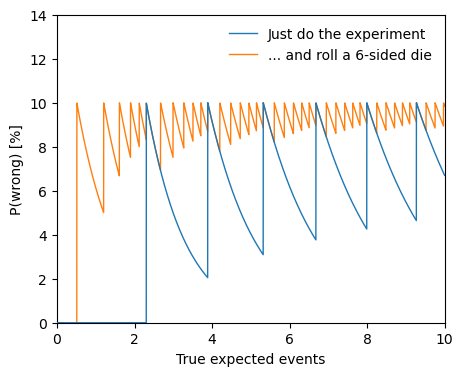

In [4]:
plt.figure(figsize=(5,4))
plt.plot(mu, 100 * poutcome_counting['mistake'], linewidth=1, label='Just do the experiment', zorder=5)
plt.plot(mu, 100 * poutcome_dice['mistake'], linewidth=1, label=f'... and roll a {die_sides}-sided die')
#plt.axhline(10, linewidth=1, label='... and roll many dice', c='C3')
plt.legend(loc='upper right', frameon=False)
plt.xlabel("True expected events")
plt.ylabel("P(wrong) [%]")
plt.ylim(0, 14)
plt.xlim(0, 10)
# plt.savefig('poisson_dice.png', dpi=200, bbox_inches='tight')

For the counting experiment, we reproduce the analytical upper limits with good accuracy (diminishing near high $n$ due to our cutoffs in $n$ and $\mu$):

In [5]:
ni_max_plot = 6

df = pd.DataFrame(dict(numerical=ul_counting[:ni_max_plot],
                  analytic=[nafi.poisson_ul(n) for n in range(ni_max_plot)]),
            ).T
df.columns = [f"saw {n_} events" for n_ in range(ni_max_plot)]
df

,saw 0 events,saw 1 events,saw 2 events,saw 3 events,saw 4 events,saw 5 events
numerical,2.302585,3.88972,5.32232,6.680783,7.993591,9.274683
analytic,2.302585,3.88972,5.32232,6.680783,7.993590,9.274674


The experiment that also throws a dice obtains considerably more stringent limits, unless the highest dice roll appears.

In [6]:
import pandas as pd
df = pd.DataFrame(ul_dice.reshape(-1, die_sides)[:ni_max_plot,:]).T.round(2)
df.index = [f"rolled a {m_ + 1}" for m_ in m]
df.columns = [f"saw {n_} events" for n_ in range(ni_max_plot)]
df

,saw 0 events,saw 1 events,saw 2 events,saw 3 events,saw 4 events,saw 5 events
rolled a 1,0.51,2.67,4.20,5.61,6.95,8.25
rolled a 2,1.20,2.99,4.48,5.87,7.20,8.49
rolled a 3,1.61,3.27,4.73,6.10,7.42,8.71
rolled a 4,1.90,3.51,4.95,6.31,7.63,8.91
rolled a 5,2.12,3.71,5.15,6.51,7.82,9.10
rolled a 6,2.30,3.89,5.32,6.68,7.99,9.27


Clearly the sensitivity (median result when no signal is present) is much better than the 2.3 events of the pure counting experiment. For a die with many sides, this can get as low as 1.61 events.

In [7]:
np.median(np.nan_to_num(ul_dice[:die_sides]))

1.753279422264797